In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from IPython.display import clear_output 

In [3]:
#Importing the dataset 

#number of individual 
n_obs = 12
#PVC total count 
PVC_tot = np.array([11, 11, 17, 22, 9, 6, 5, 14, 9, 7, 22, 51])

#before drugs 
before_drugs = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])

#after drugs 
after_drugs = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])

hearts = np.vstack((PVC_tot, before_drugs, after_drugs))
hearts = hearts.T
print("---------------------------------------------")
print(pd.DataFrame(hearts, columns = ["PVC_tot", "before_drugs", "after_drugs"]))

---------------------------------------------
    PVC_tot  before_drugs  after_drugs
0        11             6            5
1        11             9            2
2        17            17            0
3        22            22            0
4         9             7            2
5         6             5            1
6         5             5            0
7        14            14            0
8         9             9            0
9         7             7            0
10       22             9           13
11       51            51            0


In [29]:
PVC_tot[(after_drugs == 0)]

array([17, 22,  5, 14,  9,  7, 51])

In [71]:
def Gibbs(nchain, data, sd_alpha, sd_delta, init, sigma_alpha, sigma_delta, burning, lag= 10):
    #init
    chain = np.zeros((nchain+1,2)) #alpha, delta 
    chain[0, :] = init
    
    #observation
    tot = data[:, 0]
    before  = data[:, 1]
    after = data[:, 2]
    N = len(tot)
    ########
    prob_accep = 0
    
    for i in range(nchain):
        ######### MAJ alpha ############
        new_candidate = chain[i, 0] + np.random.normal(scale= sd_alpha)
        
        top = -(new_candidate**2 / (2*sigma_alpha**2)) \
            + (np.log(np.exp(chain[i, 1])+(1+np.exp(new_candidate))**(-tot[(after == 0)] ) )).sum() \
                + new_candidate* ((after[(after != 0)])).sum() - np.log(1+np.exp(new_candidate))*(tot[(after !=0)]).sum()
            
        bottom = -(chain[i, 0]**2 / (2*sigma_alpha**2))   \
            + (np.log(np.exp(chain[i, 1])+(1+np.exp(chain[i, 0]))**(-tot[(after == 0)]))).sum() \
                + (chain[i, 0]*(after[(after != 0)])).sum() - np.log(1+np.exp(chain[i,0]))*(tot[(after !=0)]).sum()
        ratio = top -bottom

        
        u = np.log(np.random.uniform())
        if u < ratio :
            chain[i+1, 0] = new_candidate
            prob_accep += 1
        else:
            chain[i+1, 0] = chain[i, 0]
        
        ############## MAJ delta ################# 
        new_candidate = chain[i, 1] + np.random.normal(scale= sd_delta)
        
        top = -(new_candidate**2 / (2* sigma_delta**2)) - N * np.log(1+np.exp(new_candidate)) \
            + np.sum(np.log(np.exp(new_candidate) + (1+np.exp(chain[i+1, 0]))**(-tot[(after == 0)] ) ))
        
            
        bottom = -(chain[i, 1]**2 / (2*sigma_delta**2)) - N * np.log(1+np.exp(chain[i, 1])) \
            + np.sum(np.log(np.exp(chain[i, 1]) + (1+np.exp(chain[i+1, 0]))**(-tot[(after == 0)] ) ))
        
        ratio = top - bottom
        #print(ratio)
        u = np.log(np.random.uniform())
        if u < ratio :
            chain[i+1, 1] = new_candidate
            prob_accep += 1
        else:
            chain[i+1, 1] = chain[i, 1]
    #####################
        if i % 1000 == 0:
            clear_output(wait = True)
            print(f"Iteration : {i}")
        
    #burning and lag 
    index_simu = np.arange(burning, nchain+1, lag)
    chain = chain[index_simu, :]
    return chain, prob_accep/(2*nchain)
    
        
        
    

In [72]:
simu, accep = Gibbs(11000, hearts, 1, 1, np.array([0,0]), 10000, 10000, 1000, 5)

Iteration : 10000


In [73]:
accep

0.4359090909090909

In [74]:
theta = (1+np.exp(-simu[:, 1]))**(-1)
p = (1+np.exp(-simu[:, 0]))**(-1)

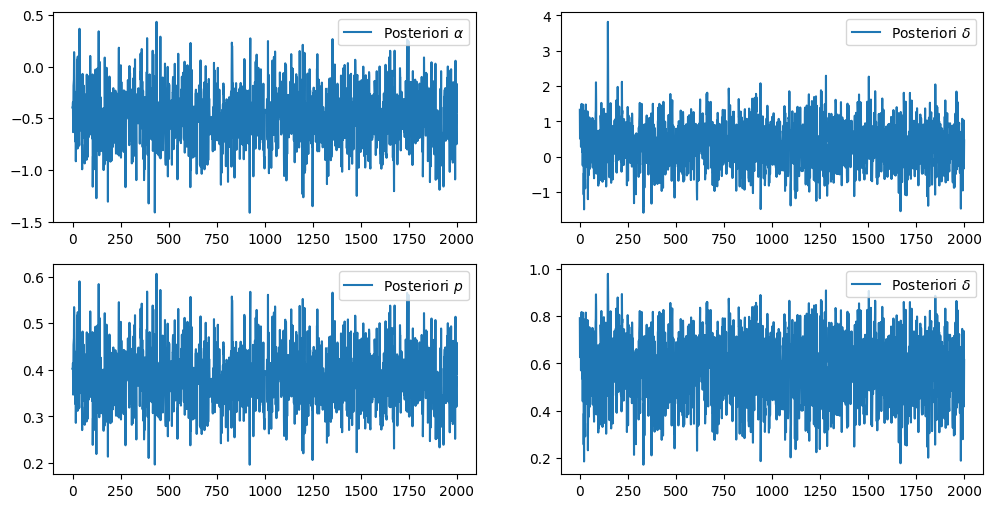

In [75]:
fig, ax = plt.subplots(2,2, figsize = (12,6))
ax[0,0].plot(simu[:, 0], label = r'Posteriori $\alpha$'); 
ax[0,0].legend()
ax[0,1].plot(simu[:, 1], label = r'Posteriori $\delta$');
ax[0,1].legend();
ax[1,0].plot(p, label = r'Posteriori $p$'); 
ax[1,0].legend()
ax[1,1].plot(theta, label = r'Posteriori $\delta$');
ax[1,1].legend();

In [76]:
#Tableau résumé : statistiques des différents paramètres ?
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de alpha {round(np.mean(simu[: , 0]), 2)} et variance de la loi a posteriori {round(np.std(simu[: , 0]), 2)}")
print(f"Estimateur en moyenne de delta {round(np.mean(simu[: , 1]),2)} et variance de la loi a posteriori {round(np.std(simu[: , 1]),2)}")
print(f"Estimateur en moyenne de p {round(np.mean(p),2)} et variance de la loi a posteriori {round(np.std(p),2)}")
print(f"Estimateur en moyenne de theta {round(np.mean(theta),2)} et variance de la loi a posteriori {round(np.std(theta),2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de alpha -0.49 et variance de la loi a posteriori 0.26
Estimateur en moyenne de delta 0.33 et variance de la loi a posteriori 0.62
Estimateur en moyenne de p 0.38 et variance de la loi a posteriori 0.06
Estimateur en moyenne de theta 0.58 et variance de la loi a posteriori 0.14


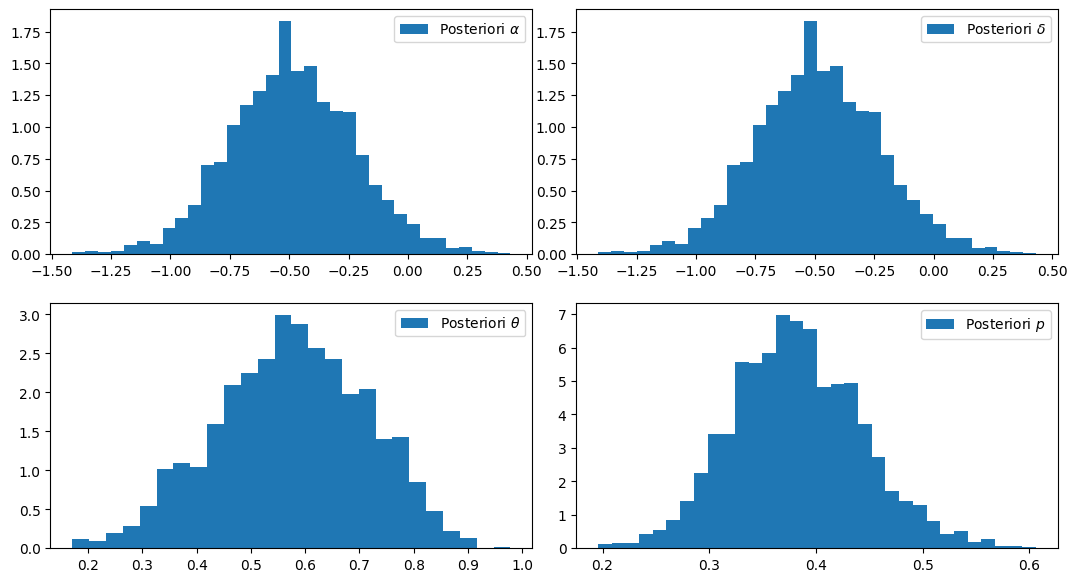

In [80]:
fig, ax = plt.subplot_mosaic([["A","A", "B","B"], ["C","C", "D", "D"]], figsize = (13, 7))

ax["A"].hist(simu[:, 0], label= r"Posteriori $\alpha$", bins = 'auto', density = True)
ax["A"].legend()
ax["B"].hist(simu[:, 0], label= r"Posteriori $\delta$", bins = 'auto', density = True)
ax["B"].legend()
ax["C"].hist(theta, label = r"Posteriori $\theta$", bins = 'auto', density = True)
ax["C"].legend()
ax["D"].hist(p, label= r"Posteriori $p$", bins = 'auto', density = True)
ax["D"].legend()

In [91]:
import scipy.stats as stats
beta = np.exp(simu[:, 0])
nparam_density = stats.gaussian_kde(beta)
map_beta = beta[np.argsort(nparam_density)[-1]]
print(f"Estimation de beta par le MAP : {map_beta}")

Estimation de beta par le MAP : 0.6719104255922649


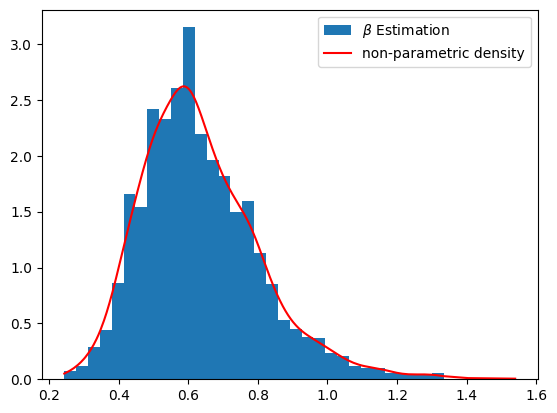

In [92]:
#Estimation de beta 
plt.hist(beta, density=True, label = r"$\beta$ Estimation", bins='auto');
plt.plot(np.sort(beta), nparam_density(np.sort(beta)), color = 'red', label = r"non-parametric density")
plt.legend();

In [94]:
np.median(beta)

0.6096535722587108

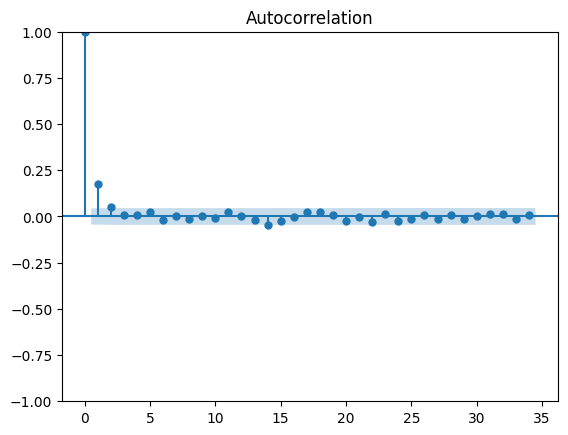

In [95]:
#auto corrélation 
from statsmodels.graphics import tsaplots
autocorr_alpha = tsaplots.plot_acf(simu[:, 0])

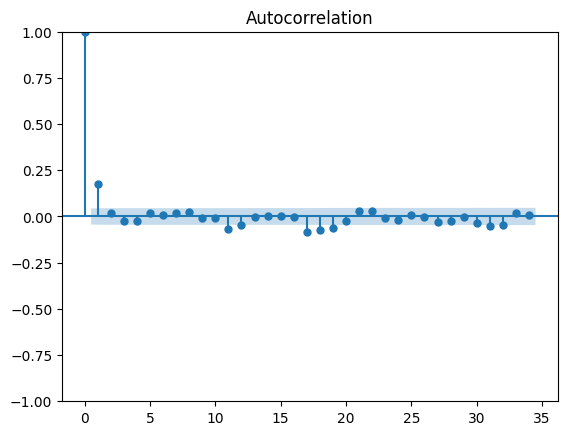

In [96]:
autocorr_delta = tsaplots.plot_acf(simu[:, 1])